In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
save_fig_path = "../reports/proposed_workflow/"

cm = 1 / 2.54  # cm to inch conversion

plt.rcParams['axes.titlesize'] = 10  # Adjust the size of the title
plt.rcParams['axes.labelsize'] = 8  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 6  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Adjust the size of the y-axis tick labels
plt.rcParams['font.size'] = 8  # General font size for all text elements
plt.rcParams['legend.fontsize'] = 6  # Font size for legend text

# Set global line width for axes and ticks
plt.rcParams['axes.linewidth'] = 0.2  # Adjust the thickness of the axes frame lines
plt.rcParams['xtick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the x-axis
plt.rcParams['ytick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the y-axis
plt.rcParams['xtick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the x-axis
plt.rcParams['ytick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the y-axis

In [6]:
path_to_metadata = "/cfs/earth/scratch/kraftjul/BA/data/dataset/info/labels/"
metadata_files = os.listdir(path_to_metadata)

In [7]:
metadata = pd.DataFrame()

for file in metadata_files:
    metadata = pd.concat([metadata, pd.read_csv(path_to_metadata + file)], ignore_index=True)

In [9]:
metadata['label2'].unique()


array(['apodemus_sp', nan, 'mustela_erminea', 'cricetidae', 'soricidae',
       'other', 'glis_glis'], dtype=object)

In [11]:
metadata["label2"].unique()

array([nan, 'apodemus_sp', 'mustela_erminea', 'soricidae', 'cricetidae',
       'other', 'glis_glis'], dtype=object)

In [12]:
metadata[metadata["label2"].isna()]

,session,SerialNumber,seq_nr,seq_id,Directory,DateTime_start,DateTime_end,duration_seconds,first_file,last_file,n_files,all_files,label,duplicate_label,label2
0,1,H,1,1000000,sessions/session_01/H_2,2019-08-29T12:54:11Z,2019-08-29T12:54:12Z,1.0,RCNX0001.JPG,RCNX0003.JPG,3,"RCNX0001.JPG,RCNX0002.JPG,RCNX0003.JPG",NaN,0.0,NaN
7,1,H550HF07158832,1,1000007,sessions/session_01/H550HF07158832,2019-09-26T08:38:36Z,2019-09-26T08:38:39Z,3.0,IMG_0001.JPG,IMG_0003.JPG,3,"IMG_0001.JPG,IMG_0002.JPG,IMG_0003.JPG",NaN,0.0,NaN
10,1,H550HF07158839,1,1000010,sessions/session_01/H550HF07158839_1,2019-08-29T23:45:49Z,2019-08-29T23:45:50Z,1.0,IMG_0001.JPG,IMG_0003.JPG,3,"IMG_0001.JPG,IMG_0002.JPG,IMG_0003.JPG",NaN,0.0,NaN
12,1,H550HF07158839,3,1000012,sessions/session_01/H550HF07158839_1,2019-09-01T00:38:54Z,2019-09-01T00:38:56Z,2.0,IMG_0019.JPG,IMG_0021.JPG,3,"IMG_0019.JPG,IMG_0020.JPG,IMG_0021.JPG",NaN,0.0,NaN
13,1,H550HF07158839,4,1000013,sessions/session_01/H550HF07158839_1,2019-09-01T20:58:12Z,2019-09-01T20:58:13Z,1.0,IMG_0022.JPG,IMG_0024.JPG,3,"IMG_0022.JPG,IMG_0023.JPG,IMG_0024.JPG",NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21698,4,H550HF08161368,240,4018689,sessions/session_04/W7-WK06,2020-07-18T09:53:02Z,2020-07-18T09:53:02Z,0.0,IMG_4273.JPG,IMG_4275.JPG,3,"IMG_4273.JPG,IMG_4274.JPG,IMG_4275.JPG",NaN,0.0,NaN
21699,4,H550HF08161368,241,4018690,sessions/session_04/W7-WK06,2020-07-18T10:38:06Z,2020-07-18T10:38:10Z,4.0,IMG_4276.JPG,IMG_4278.JPG,3,"IMG_4276.JPG,IMG_4277.JPG,IMG_4278.JPG",NaN,0.0,NaN
21701,3,H550HF07158839,2,3000001,sessions/session_03/28,2020-04-05T11:27:29Z,2020-04-05T11:27:38Z,9.0,IMG_0070.JPG,IMG_0075.JPG,6,"IMG_0070.JPG,IMG_0071.JPG,IMG_0072.JPG,IMG_007...",NaN,NaN,NaN
21702,3,H550HF07158839,3,3000002,sessions/session_03/28,2020-04-07T12:06:38Z,2020-04-07T12:06:46Z,8.0,IMG_0076.JPG,IMG_0084.JPG,9,"IMG_0076.JPG,IMG_0077.JPG,IMG_0078.JPG,IMG_007...",NaN,NaN,NaN


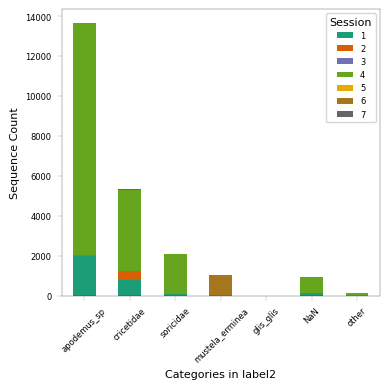

In [50]:


df = metadata.copy()
df["label2"] = df["label2"].fillna("NaN")

counts = df.groupby(["label2", "session"]).size().unstack(fill_value=0)
counts["total"] = counts.sum(axis=1)

special_labels = ["NaN", "other"]

regular = counts[~counts.index.isin(special_labels)].sort_values("total", ascending=False)
special = counts[counts.index.isin(special_labels)]

counts_sorted = pd.concat([regular, special])
counts_sorted = counts_sorted.drop(columns="total")

# Create figure
fig, ax = plt.subplots(figsize=(10 * cm, 10 * cm))

counts_sorted.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Dark2"
)

ax.set_xlabel("Categories in label2")
ax.set_ylabel("Sequence Count")
ax.tick_params(axis='x', rotation=45)
ax.legend(title="Session", loc='upper right')

plt.tight_layout()
plt.savefig(f'{save_fig_path}label2_session.pdf', dpi=300)

plt.show()

